In [9]:
import numpy as np
from dataclasses import dataclass

import mpmath
from mpmath import mpf
mpmath.mp.dps = 24

from compute_rate_data import *

## Fixed values

In [10]:
# Which plot?

plot_index = 0

In [11]:
@dataclass
class DatasetConfig:
    label_locations: list[tuple[float, float]]
    M_lim: tuple[int, int]
    p_bell: float
    p_target: float
    sequence_file: str
    PD_2nd_stage_index: int = None

configs = [
    DatasetConfig(
        label_locations=[(5e1, 9000), (8e-1, 4500), (1e-2, 13_000)],
        M_lim=(0, 20_000),
        p_bell=mpf("1e-2"),
        p_target=mpf("1e-12"),
        sequence_file="data/sequences_12.dat",
    ),
    DatasetConfig(
        label_locations=[(70, 1700), (0.15, 1200), (0.075, 2300)],
        M_lim=(100, 20_000),
        p_bell=mpf("1e-2"),
        p_target=mpf("1e-6"),
        sequence_file="data/sequences_06.dat",
    ),
    DatasetConfig(
        label_locations=[(1e2, 2500), (1, 1000), (1e-2, 6000)],
        M_lim=(100, 10_000),
        p_bell=mpf("5e-2"),
        p_target=mpf("1e-6"),
        sequence_file="data/sequences_6_pb5.dat",
        PD_2nd_stage_index=1
    ),
    DatasetConfig(
        label_locations=[None, (0.1, 5000), (0.1, 10_000)],
        M_lim=(0, 20_000),
        p_bell=mpf("1e-2"),
        p_target=mpf("1e-12"),
        sequence_file="data/sequences_12_nn.dat",
    ),
]

In [12]:
# Common params between all
p_physical = mpf("0.1e-2")
p_idle = mpf("1e-6")

In [13]:
if not (0 <= plot_index < len(configs)):
    raise ValueError("Undefined plot_index.")

config = configs[plot_index]

absolute_label_locations = config.label_locations
p_bell = config.p_bell
p_target = config.p_target
sequence_file = config.sequence_file
PD_2nd_stage_index = config.PD_2nd_stage_index

In [14]:
# Setup parameter space for plotting
# r_rel = (0.5e-1, 0.5e4)
r_rel = (0.5e-3, 0.5e4)
resolution = 200

Ms = np.linspace(*config.M_lim, resolution).astype(int)
r_rel = np.logspace(np.log10(r_rel[0]), np.log10(r_rel[1]), resolution)
X, Y = np.meshgrid(r_rel, Ms, indexing="ij")
shape = X.shape

In [15]:
def get_rate_args(config_index: int) -> RateArgs:
    config = configs[config_index]
    return RateArgs(
        r_rel,
        np.linspace(*config.M_lim, resolution).astype(int),
        config.p_target,
        p_physical,
        config.p_bell,
        p_idle,
        config.sequence_file
    )

## Prepare data

In [16]:
# Compute rates for each method
rate_data: RateData = compute_rate_data(get_rate_args(plot_index), do_T=True)

# # Save data to file to use with interactive plot
# path = "data/plot_12_full.dat"
# data = {
#     "rates": [arr.astype(float).tolist() for arr in rate_data.rs],
#     "labels": rate_data.rate_labels,
#     "x": r_rel.tolist(),
#     "y": Ms.tolist(),
# }
# with open(path, 'w') as file:
#     json.dump(data, file)

Computing transversal gate rates.
Computing lattice surgery rates.
Computing distillation rate
Total number of sequences: 841
Number of unique sequences: 66


In [17]:
# Distillation with initial physical distillation
rate_labels2 = [label + " + PD" for label in rate_data.rate_labels]
if PD_2nd_stage_index is not None:
    second_stage_data = compute_rate_data(get_rate_args(PD_2nd_stage_index))
    Z2, ids2 = add_physical_distillation(r_rel, Ms, second_stage_data)
else:
    Z2, ids2 = np.zeros(shape), np.full(shape, -1)

## Plotting of data

In [18]:
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import patheffects as mplpe
import matplotlib.patches as patches

plt.close("all")
%matplotlib widget

# General styling
greyscale = True
cmap = 'gray' if greyscale else 'viridis'
text_tyling = [mplpe.withStroke(linewidth=2, foreground="w", alpha=1.0)] if greyscale else []

In [19]:
L_local = rate_data.memory_unit
memory_unit = surface_code_qubits(rate_data.memory_unit, rotated=False)

Z, ids = rate_data.Z.astype(float), rate_data.ids

# Ordering should match rate_data.rate_labels!
rate_labels = rate_data.rate_labels
rs_T, rs_LS, rs_D = rate_data.rs

In [20]:
# # Testing of physical distillation transformation

# # Plot physcal distillation rates
# xs = np.logspace(np.log10(2e-1), np.log10(5e2), 200)
# ys = np.linspace(0, 5_000, 200).astype(int)

# rs_PD = np.zeros((len(xs), len(ys)))
# pd_rate = PhysicalDistillationRateExtrapolator("./data/physical_distillation.dat", max_mem=ys[-1])
# for i, j in np.ndindex(rs_PD.shape):
#     rs_PD[i, j] = pd_rate.eval(xs[i], ys[j])

# fig, ax = plt.subplots(figsize=(10, 5))
# c = ax.pcolormesh(*np.meshgrid(xs, ys, indexing="ij"), rs_PD, shading='auto', cmap=cmap, norm='log')
# fig.colorbar(c, ax=ax, label='r_distil/r_physical')
# # ax.plot(pd_rate.xs, pd_rate.ys, "k--", dashes=(5, 10))

# # Styling
# ax.set_xlabel('r_bell/r_physical')
# ax.set_ylabel('Allocated memory')
# ax.set_xscale("log")
# ax.set_xlim(xs[0], xs[-1])
# ax.set_ylim(ys[0], ys[-1])

# plt.tight_layout()
# plt.show()

# # Points in final plot. The rates are optimised over second stage and physical distillation.
# points = [(1e2, 1400), (1e2, 1600), (1e2, 2000), (1e2, 3500), (1e3, 8000)]

# xt, yt = np.meshgrid(second_stage_data.r_rel, second_stage_data.Ms, indexing="ij") 
# # Plot full 3D plot with added physical distillation
# fig, ax = plt.subplots(figsize=(10, 5))
# c = ax.pcolormesh(xt, yt, second_stage_data.Z.astype(float), shading='auto', cmap=cmap, norm='log')
# fig.colorbar(c, ax=ax, label='r_distributed/r_logical')
# # Add regions
# for id in np.unique(ids):
#     ax.contour(xt, yt, second_stage_data.ids==id, levels=[0.5], colors='black', linewidths=1, corner_mask=False, linestyles="-")
# ax.set_xscale("log")

# pd = PhysicalDistillationRateExtrapolator("./data/physical_distillation.dat")
# for point in points:
#     line_m = np.arange(point[1])
#     line_r = [pd.eval(point[0], point[1] - m) for m in line_m]
#     plt.plot(line_r, line_m, "r-")

#     line_z = []
#     line_id = []
#     for m, r in zip(line_m, line_r):
#         x_idx = bisect_right(second_stage_data.r_rel, r) - 1
#         y_idx = bisect_right(second_stage_data.Ms, m) - 1
#         if x_idx < 0 or y_idx < 0:
#             # Transformed value fall outside of known region
#             continue
#         line_z.append(second_stage_data.Z[x_idx, y_idx])
#         line_id.append(second_stage_data.ids[x_idx, y_idx])
#     idx = len(line_z) - 1 - np.argmax(list(reversed(line_z)))
#     plt.plot([line_r[idx]], [line_m[idx]], "g*")

# plt.ylim(0, 10_000)
# plt.tight_layout()
# plt.show()

# # Plot full 3D plot with added physical distillation
# fig, ax = plt.subplots(figsize=(10, 5))
# c = ax.pcolormesh(X, Y, Z2 , shading='auto', cmap=cmap, norm='log')
# fig.colorbar(c, ax=ax, label='r_distributed/r_logical')
# # Add regions
# for id in np.unique(ids2):
#     ax.contour(X, Y, ids2==id, levels=[0.5], colors='black', linewidths=1, corner_mask=False, linestyles="-")

# # Point
# for point in points:
#     plt.plot([point[0]], [point[1]], "*r")

# # Styling
# y_ax2 = ax.secondary_yaxis(-0.13, (lambda x: x/memory_unit, lambda x: x * memory_unit))
# # ax.set_ylim(Ms[0], 13_000)
# ax.set_xlabel('r_bell/r_physical')
# ax.set_ylabel('Allocated memory')
# ax.set_xscale("log")

# plt.tight_layout()
# plt.show()

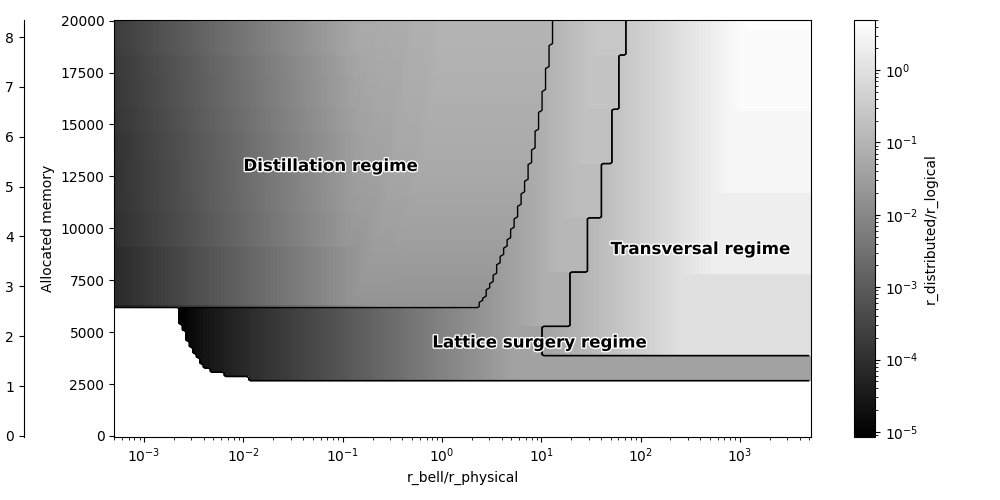

['Transversal', 'Lattice surgery', 'Distillation']


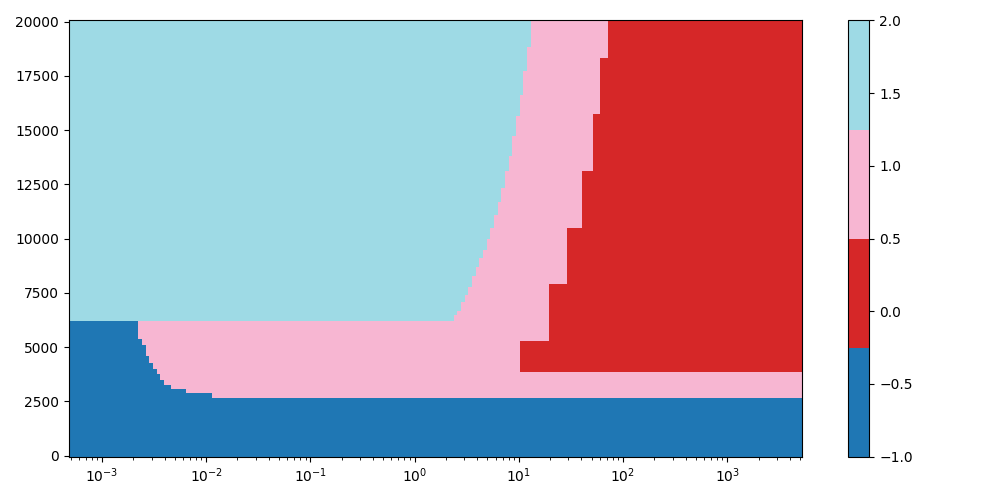

In [ ]:
# Combine rates with and without physical distillation
mask = Z2 > Z
Z_max = np.where(mask, Z2, Z)
ids_max = np.where(mask, ids2, ids)

# Plot rate plot
fig, ax = plt.subplots(figsize=(10, 5))
c = ax.pcolormesh(X, Y, Z_max , shading='auto', cmap=cmap, norm='log')
# c.set_edgecolor('face')
fig.colorbar(c, ax=ax, label='r_distributed/r_logical')
# Add regions
for id, lab, loc in zip(np.unique(ids_max), rate_labels + rate_labels2, absolute_label_locations):
    ax.contour(X, Y, ids_max==id, levels=[0.5], colors='black', linewidths=1, corner_mask=False, linestyles="-")
    plt.text(*loc, lab + " regime", color='black', fontsize=12, fontweight='bold', ha='left', va='center', path_effects=text_tyling)

# Styling
y_ax2 = ax.secondary_yaxis(-0.13, (lambda x: x/memory_unit, lambda x: x * memory_unit))
# ax.set_ylim(Ms[0], 13_000)
ax.set_xlabel('r_bell/r_physical')
ax.set_ylabel('Allocated memory')
ax.set_xscale("log")

plt.tight_layout()
# plt.savefig('top_view_12.eps', format='eps')
plt.show()

# Plot regions with IDs for double checking
print(rate_labels)
ids_max = ids_max = np.where(mask, ids2 + len(rate_labels), ids)
plt.figure(figsize=(10, 5))
num_ids = np.max(ids_max) + 2
plt.pcolormesh(X, Y, ids_max, cmap=plt.get_cmap('tab20', num_ids), shading='auto')
plt.colorbar()
plt.xscale("log")
plt.tight_layout()
plt.show()

## Stylised plots

In [ ]:
# Memory slice
M = 10_000
# Rate slice
r = 1.0

# Get data
data = compute_rate_data(RateArgs(
    r_rel,
    [M],
    mpf("1e-12"),
    p_physical,
    mpf("1e-2"),
    p_idle,
    "data/sequences_12.dat",
))

slice_T = data.rs[0].squeeze()
slice_LS = data.rs[1].squeeze()
slice_D = data.rs[2].squeeze()

memory_unit = surface_code_qubits(data.memory_unit, rotated=False)

sty_Ms = np.linspace(4_000, 25_000, 500).astype(int)
growing = 5 * compute_distillation_data("./data/sequences_12.dat", [r], sty_Ms).squeeze()
no_growing = 5 * compute_distillation_data("./data/sequences_12_no_growing.dat", [r], sty_Ms).squeeze()

Computing transversal gate rates.
Computing lattice surgery rates.
Computing distillation rate
Total number of sequences: 841
Number of unique sequences: 66
Total number of sequences: 841
Number of unique sequences: 66
Total number of sequences: 528
Number of unique sequences: 25


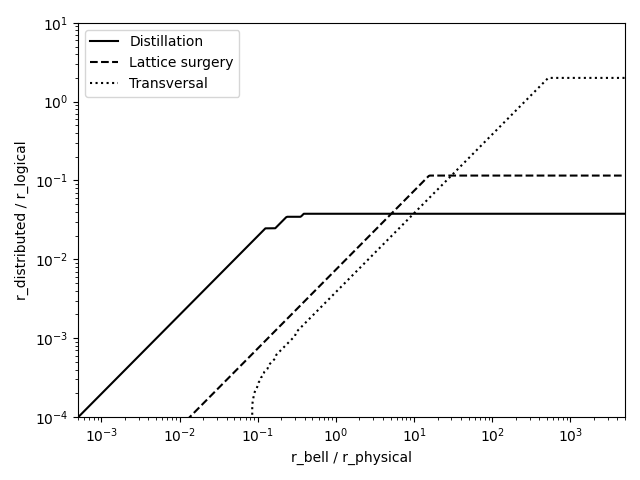

Smallest absolute difference: 1.85758632659062625513657


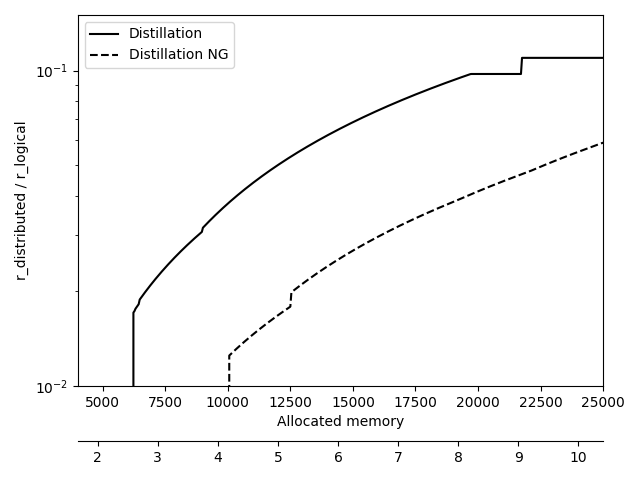

In [ ]:
# Plot memory slice
plt.figure()
x = r_rel
plt.plot(x, slice_D , "k-", label="Distillation")
plt.plot(x, slice_LS , "k--", label="Lattice surgery")
plt.plot(x, slice_T , "k:", label="Transversal")
plt.xlim(r_rel[0], r_rel[-1])
plt.ylim(5*5 * 4e-6, 5 *5* 4e-1)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("r_bell / r_physical")
plt.ylabel("r_distributed / r_logical")
plt.legend()
plt.tight_layout()
plt.show()
# plt.savefig("methods.pdf")

nonzero = np.nonzero(no_growing)
diff = growing[nonzero] / no_growing[nonzero]
if diff.size > 0:
    print("Smallest absolute difference:", np.min(diff))

fig, ax = plt.subplots()
x = sty_Ms
plt.plot(x, growing , "k-", label="Distillation")
plt.plot(x, no_growing , "k--", label="Distillation NG")

x_ax2 = ax.secondary_xaxis(-0.15, (lambda x: x/memory_unit, lambda x: x * memory_unit))
# x_ax2.set_ylabel(f"In units of L={L_D} qubits")

plt.ylim(1e-2, 1.5e-1)
plt.xlim(x[0], x[-1])
plt.yscale("log")
plt.xlabel("Allocated memory")
plt.ylabel("r_distributed / r_logical")
plt.legend()
plt.tight_layout()
plt.show()
# plt.savefig("distillations.pdf")


In [ ]:
# Memory slice with different sequence use
M = 15_000
xlim = (0.09, 2)
ylim = (2e-2, 1e-1)

xs = np.logspace(np.log10(xlim[0]), np.log10(xlim[1]), 500)

seqs = load_sequences("data/sequences_12_M15000.dat")[15000]
# multiply by 5 to get in units of logical gate rate
full_params = [(seq.encoding_rate * 5, seq.input_rate_cap(M)) for seq in seqs]
reduced_params = [
    max(full_params, key=lambda p: p[0]), 
    max(full_params, key=lambda p: p[0]*p[1])
]

fill_optim = 5 * compute_distillation_data("data/sequences_12.dat", xs, [M]).squeeze()
full_optim = np.zeros_like(fill_optim)
reduced_optim = np.zeros_like(fill_optim)
for E, C in full_params:
    full_optim = np.maximum(full_optim, E * np.minimum(xs, C))
for E, C in reduced_params:
    reduced_optim = np.maximum(reduced_optim, E * np.minimum(xs, C))

Total number of sequences: 841
Number of unique sequences: 66


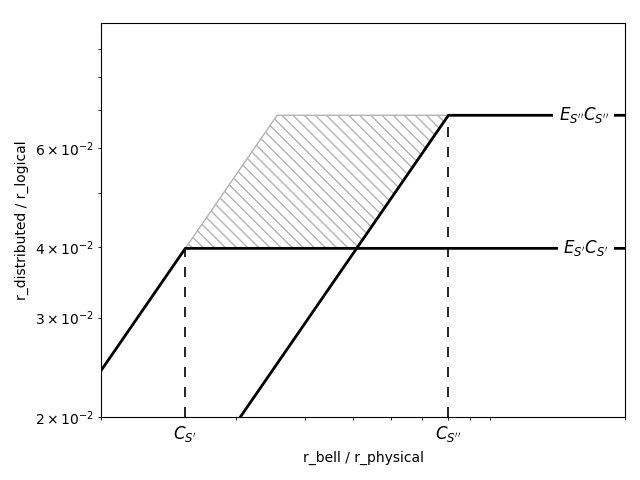

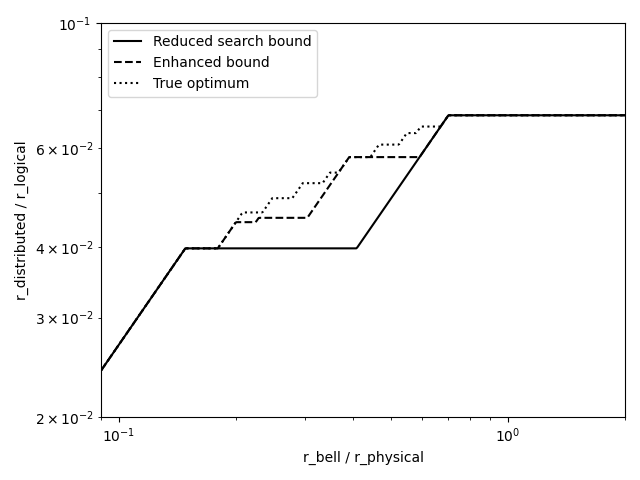

In [ ]:
# Make illustration
start, end = xlim
bottom, top = ylim

e1, c1 = reduced_params[0]
e2, c2 = reduced_params[1]
e1, e2 = e1, e2
cap1, cap2 = e1*c1, e2*c2

vertices = [
    [c1, cap1],
    [cap1/e2, cap1],
    [c2, cap2],
    [cap2/e1, cap2],
]
poly = patches.Polygon(
    vertices,
    closed=True,
    facecolor='none',
    edgecolor='0.7',
    hatch='\\\\\\',
    linewidth=1
)

plt.figure()
ax = plt.subplot()
ax.plot([start, c1, end], [start*e1, cap1, cap1], "k-", linewidth=2)
ax.plot([start, c2, end], [start*e2, cap2, cap2], "k-", linewidth=2)

ax.plot([c1, c1], [bottom, cap1], "k--", linewidth=1.2, dashes=(6, 6))
ax.plot([c2, c2], [bottom, cap2], "k--", linewidth=1.2, dashes=(6, 6))
ax.text(c1, bottom / 1.03, "$C_{S'}$", ha='center', va='top', fontsize=12)
ax.text(c2, bottom / 1.03, "$C_{S''}$", ha='center', va='top', fontsize=12)

# ax.plot([start, c1], [cap1, cap1], "k--", linewidth=1.2, dashes=(6, 6))
# ax.plot([start, c2], [cap2, cap2], "k--", linewidth=1.2, dashes=(6, 6))
ax.text(end / 1.1, cap1, "$E_{S'} C_{S'}$", ha='right', va='center', fontsize=12, bbox=dict(linewidth=0, facecolor='white', alpha=1.0))
ax.text(end / 1.1, cap2, "$E_{S''} C_{S''}$", ha='right', va='center', fontsize=12, bbox=dict(linewidth=0, facecolor='white', alpha=1.0))

ax.add_patch(poly)

plt.xlim(*xlim)
plt.ylim(*ylim)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("r_bell / r_physical")
plt.ylabel("r_distributed / r_logical")
plt.tick_params(colors="w")
plt.tight_layout()
plt.show()
# plt.savefig("reduced_optimisation.pdf")

# Plot stylised memory slice with full optimisation
plt.figure()
plt.plot(xs, reduced_optim , "k-", label="Reduced search bound")
plt.plot(xs, fill_optim , "k--", label="Enhanced bound")
plt.plot(xs, full_optim , "k:", label="True optimum")

plt.xlim(*xlim)
plt.ylim(*ylim)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("r_bell / r_physical")
plt.ylabel("r_distributed / r_logical")
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()
# plt.savefig("complete_optimisation.pdf")